In [1]:
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import folium
import matplotlib.colors as mcolors
import scipy.stats as stats

In [2]:
df=pd.read_csv('/content/군집분석_최종_df(3).csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율
0,종로구,41.46,9.95,23.99,0,서울특별시,116.49,85.6,13.45,0.001464
1,중구,77.21,7.71,9.99,0,서울특별시,116.49,85.6,13.45,0.001464
2,용산구,48.26,10.57,21.89,0,서울특별시,116.49,85.6,13.45,0.001464
3,성동구,64.81,10.90,16.82,0,서울특별시,116.49,85.6,13.45,0.001464
4,광진구,63.49,10.82,17.05,0,서울특별시,116.49,85.6,13.45,0.001464


##Preprocessing

In [4]:
# '행정구역면적(㎢)' 컬럼의 값을 float로 변환
df['행정구역면적(㎢)'] = df['행정구역면적(㎢)'].str.replace(',', '')  # 쉼표 제거
df['행정구역면적(㎢)'] = df['행정구역면적(㎢)'].astype(float)  # float로 변환

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일링
scaler = MinMaxScaler()
scaling_columns = ['불투수면 비율(%)', '불투수면 면적(㎢)', '행정구역면적(㎢)', '농업면적',
                   '농가인구비율', '연평균강수량', '해발고도', '연평균기온']

df[scaling_columns] = scaler.fit_transform(df[scaling_columns])
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율
0,종로구,0.482083,0.045114,0.011554,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
1,중구,0.911977,0.031476,0.003840,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
2,용산구,0.563853,0.048889,0.010397,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
3,성동구,0.762867,0.050898,0.007604,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
4,광진구,0.746994,0.050411,0.007731,0.0,서울특별시,0.294639,0.105457,0.601286,0.0


##Truncated SVD

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_sparse_coded_signal

X = df[[col for col in df.columns if col != '시도시군구']].copy()
X = X[[col for col in X.columns if col != '시도구분']].copy()

# Truncated SVD 모델 생성
n_components = 2  # 축소할 차원 수
svd = TruncatedSVD(n_components=n_components, random_state=42)

# 모델 학습 및 변환
X_transformed = svd.fit_transform(X)

# 결과 확인
print(f"원래 데이터 차원: {X.shape}")
print(f"축소된 데이터 차원: {X_transformed.shape}")


원래 데이터 차원: (250, 9)
축소된 데이터 차원: (250, 2)


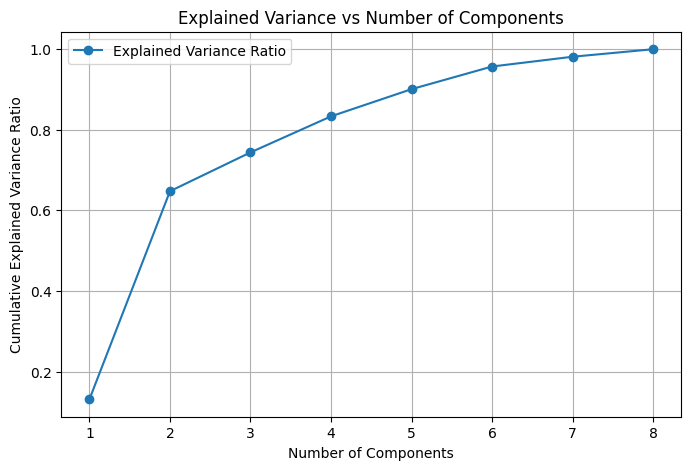

최적의 차원 수: 6


In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_sparse_coded_signal
import numpy as np

# 설명된 분산 비율 계산
explained_variance_ratios = []
component_range = range(1, 9)
for n_components in component_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X)
    explained_variance_ratios.append(np.sum(svd.explained_variance_ratio_))

# 최적 차원 찾기 (설명된 분산 비율 기준, 95% 이상)
optimal_dim = next(
    (i + 1 for i, ratio in enumerate(explained_variance_ratios) if ratio >= 0.95), len(component_range)
)

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(component_range, explained_variance_ratios, marker='o', label='Explained Variance Ratio')
#plt.axvline(optimal_dim, color='r', linestyle='--', label=f'Optimal Dim: {optimal_dim}')
plt.title("Explained Variance vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.legend()
plt.grid()
plt.show()

print(f"최적의 차원 수: {optimal_dim}")


In [8]:
# 2차원에서 설명된 분산 비율 계산
singular_values_2d = svd.singular_values_
total_variance_2d = np.sum(svd.singular_values_**2)  # 전체 분산은 원래 SVD 기준으로 동일
explained_variance_ratio_2d = (singular_values_2d**2) / total_variance_2d
cumulative_variance_2d = np.cumsum(explained_variance_ratio_2d)

print("2차원에서 설명된 분산 비율:")
print(explained_variance_ratio_2d)
print("누적 설명된 분산 비율:")
print(cumulative_variance_2d)

2차원에서 설명된 분산 비율:
[0.7456702  0.15234368 0.02790256 0.02587189 0.01949845 0.01627681
 0.00703952 0.00539689]
누적 설명된 분산 비율:
[0.7456702  0.89801388 0.92591644 0.95178834 0.97128678 0.9875636
 0.99460311 1.        ]


In [14]:
# 컬럼 이름과 주성분 행렬 확인
columns = X.columns
assert len(columns) == svd.components_.shape[1], "컬럼 개수와 주성분 행렬의 열 개수가 맞지 않습니다."

# 주성분 데이터프레임 생성
principal_components = pd.DataFrame(
    svd.components_,
    columns=columns,
    index=[f"Component {i+1}" for i in range(svd.components_.shape[0])]
)

# 결과 출력
print(principal_components)


             불투수면 비율(%)  불투수면 면적(㎢)  행정구역면적(㎢)      농업면적    연평균강수량      해발고도  \
Component 1    0.241776    0.227778   0.261646  0.090984  0.330865  0.145589   
Component 2    0.608821   -0.112032  -0.335140 -0.156881  0.183539  0.092485   
Component 3   -0.076572    0.330461   0.509849  0.554331 -0.035547  0.101461   
Component 4   -0.399713    0.000598   0.155642 -0.444972  0.508473  0.562577   
Component 5   -0.208002    0.599301  -0.014967 -0.464664  0.021254 -0.559009   
Component 6    0.515990    0.241236   0.434807 -0.411666 -0.376157  0.238863   

                연평균기온    농가인구비율  
Component 1  0.658579  0.498529  
Component 2  0.302675 -0.588220  
Component 3  0.047405 -0.551270  
Component 4 -0.093668 -0.184916  
Component 5  0.189090 -0.180937  
Component 6 -0.329050  0.101046  


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

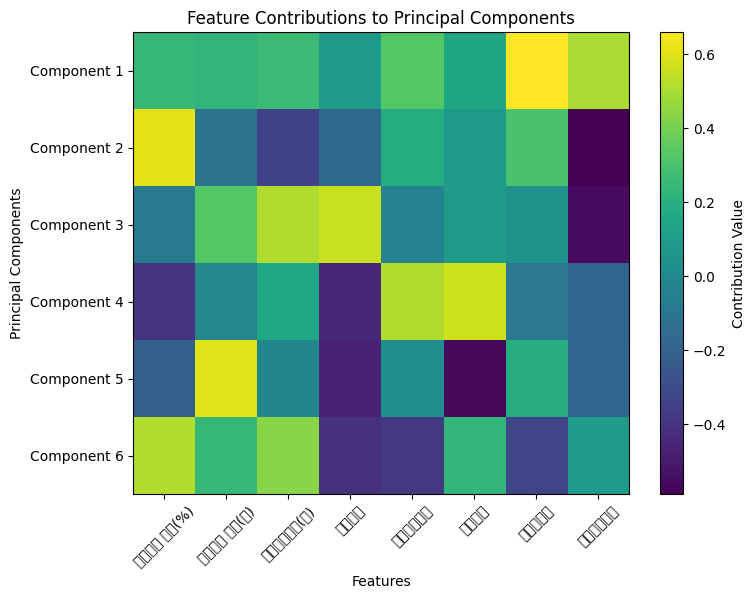

In [15]:
# Principal components and explained variance
components = principal_components.values
explained_variance = explained_variance_ratio_2d

# Heatmap for component contributions
plt.figure(figsize=(8, 6))
plt.imshow(components, cmap='viridis', aspect='auto')
plt.colorbar(label="Contribution Value")
plt.title("Feature Contributions to Principal Components")
plt.xticks(ticks=np.arange(len(columns)), labels=columns, rotation=45)
plt.yticks(ticks=np.arange(len(components)), labels=[f"Component {i+1}" for i in range(len(components))])
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.show()

##K-means 군집분석

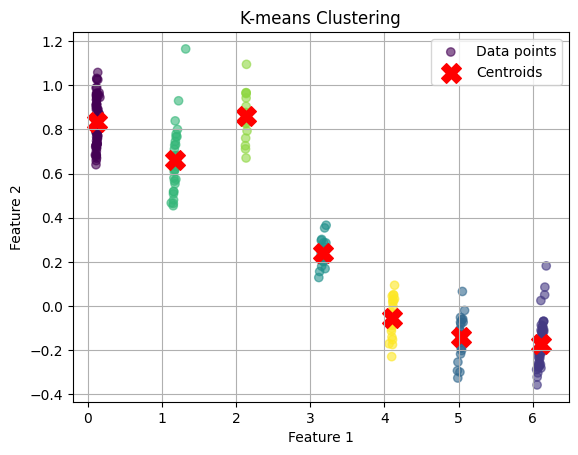

클러스터 중심점:
[[ 0.12186158  0.83204147]
 [ 6.11073856 -0.17005517]
 [ 5.03222348 -0.1407966 ]
 [ 3.17295534  0.23960109]
 [ 1.18104157  0.65938503]
 [ 2.13376144  0.8589446 ]
 [ 4.10791685 -0.05452352]]


In [27]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# K-means 모델 생성
n_clusters = 7 # 클러스터 개수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# 데이터 클러스터링
kmeans.fit(X_transformed)
labels = kmeans.labels_  # 각 데이터가 속한 클러스터
centroids = kmeans.cluster_centers_  # 클러스터 중심점

# 결과 시각화
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

print(f"클러스터 중심점:\n{centroids}")


###최적의 k값 찾기

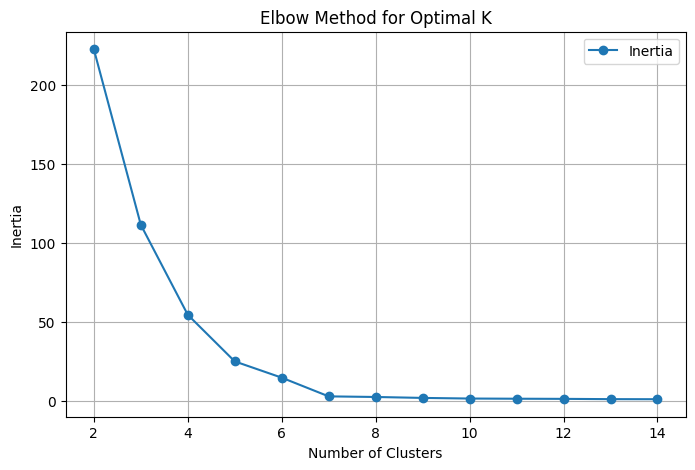

In [25]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 엘보우 메소드
inertia = []
silhouette_scores = []
cluster_range = range(2, 15)  # 클러스터 개수 범위

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)  # 클러스터 내 거리의 합
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))  # 실루엣 계수

# 엘보우 그래프
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.legend()
plt.show()


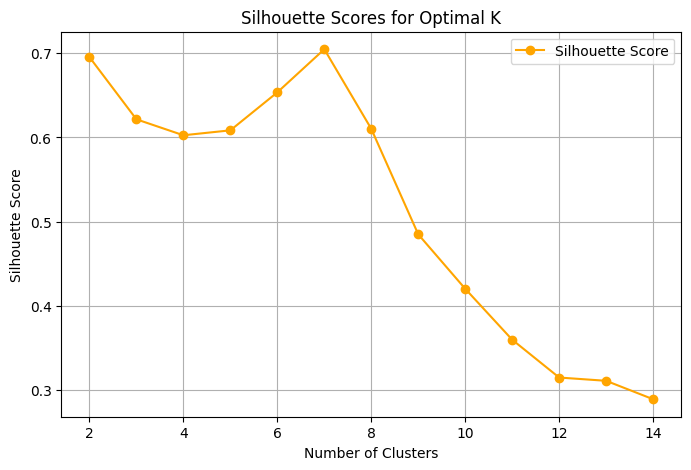

최적 클러스터 개수 (실루엣 기준): 7


In [26]:
# 실루엣 계수 그래프
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Scores for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.legend()
plt.show()

# 최적 클러스터 개수 출력
optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"최적 클러스터 개수 (실루엣 기준): {optimal_k}")


###clustering 결과

In [28]:
# 라벨을 df에 cluster 컬럼으로 추가
df['cluster'] = labels
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율,cluster
0,종로구,0.482083,0.045114,0.011554,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
1,중구,0.911977,0.031476,0.003840,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
2,용산구,0.563853,0.048889,0.010397,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
3,성동구,0.762867,0.050898,0.007604,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
4,광진구,0.746994,0.050411,0.007731,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0


In [29]:
# 시도구분을 기준으로 cluster 분포 집계
cluster_distribution = df.groupby('시도구분')['cluster'].value_counts().unstack(fill_value=0)
cluster_distribution

cluster,0,1,2,3,4,5,6
시도구분,,,,,,,
강원특별자치도,0,1,0,0,2,0,15
경기도,25,0,17,0,0,0,0
경상남도,0,0,0,3,17,0,2
경상북도,0,10,0,11,0,0,2
광주광역시,4,0,1,0,0,0,0
대구광역시,6,0,3,0,0,0,0
대전광역시,3,0,2,0,0,0,0
부산광역시,0,0,0,0,0,16,0
서울특별시,25,0,0,0,0,0,0


In [30]:
# 각 클러스터에 포함된 데이터 개수 계산
cluster_counts = np.bincount(labels)

# 결과 출력
for cluster_id, count in enumerate(cluster_counts):
    print(f"클러스터 {cluster_id}: {count}개")

클러스터 0: 74개
클러스터 1: 51개
클러스터 2: 28개
클러스터 3: 20개
클러스터 4: 34개
클러스터 5: 16개
클러스터 6: 27개


In [31]:
#클러스터 별 컬럼 특징 확인
X['cluster'] = labels
grouped = pd.DataFrame(X.groupby('cluster').agg(['mean', 'std']))
grouped

불투수면 비율(%)           불투수면 면적(㎢)           행정구역면적(㎢)            \
              mean       std       mean       std      mean       std   
cluster                                                                 
0         0.523818  0.198752   0.090415  0.058749  0.023457  0.017509   
1         0.101680  0.072258   0.294174  0.131227  0.320262  0.134338   
2         0.145778  0.070929   0.317134  0.194367  0.249195  0.133184   
3         0.048130  0.029199   0.271732  0.113848  0.495841  0.118917   
4         0.141938  0.088505   0.219105  0.148638  0.191118  0.116776   
5         0.523073  0.227392   0.071587  0.075310  0.025387  0.034626   
6         0.029626  0.018078   0.179676  0.076168  0.492634  0.189304   

             농업면적              연평균강수량                해발고도               연평균기온  \
             mean       std      mean       std      mean       std      mean   
cluster                                                                         
0        0.000895  0.004113  0.251963  0.086633  0.090148  0.015765  0.605255   
1        0.040642  0.089203  0.290073  0.102769  0.090030  0.063820  0.623364   
2        0.073594  0.135330  0.248881  0.096989  0.087353  0.018060  0.573228   
3        0.561763  0.181521  0.207830  0.100497  0.088523  0.050940  0.598136   
4        0.057695  0.102926  0.398436  0.178293  0.057614  0.028084  0.672697   
5        0.000000  0.000000  0.618426  0.000000  0.507261  0.000000  0.822079   
6        0.032852  0.082011  0.254519  0.090245  0.307751  0.204891  0.418320   

                     농가인구비율            
              std      mean       std  
cluster                                
0        0.071919  0.072100  0.057425  
1        0.094241  0.849175  0.139402  
2        0.091505  0.119073  0.030397  
3        0.069745  0.725636  0.177437  
4        0.096662  0.520261  0.089521  
5        0.000000  0.036075  0.000000  
6        0.119721  0.610934  0.088934

In [32]:
df.to_csv('군집분석_완료_df(1).csv')

##지역 작물 mapping

In [35]:
df=pd.read_csv('/content/군집분석_완료_df(1).csv').drop(columns='Unnamed: 0')
crop=pd.read_csv('/content/매핑_result (9).csv',encoding='euc-kr')

In [44]:
import re

# 지역 데이터
df['지점명']=df['시도구분']+" "+df['시도시군구']
cluster_groups = df.groupby('cluster')['지점명'].apply(list)

# 클러스터 딕셔너리 생성
clusters = {cluster: locations for cluster, locations in cluster_groups.items()}

# 작물 데이터 딕셔너리 생성
crops = {
    "고구마": ["경상북도 청송군", "경상북도 울진군", "경상북도 영덕", "경상북도 봉화군", "강원특별자치도 동해시", "강원특별자치도 태백시", "강원특별자치도 평창군", "경상북도 포항시 남구", "경상북도 포항시 북구", "강원특별자치도 속초시"],
    "당근": ["제주특별자치도 제주시", "제주특별자치도 제주시", "전라남도 광양시", "경상남도 양산시", "완도군 전라남도", "경상남도 거제시", "제주특별자치도 제주시", "전라남도 목포시", "강원특별자치도 동해시", "제주특별자치도 서귀포시"],
    "대파": ["전라남도 순천시", "전라남도 강진군", "전라남도 장흥군", "경상북도 영덕군", "제주특별자치도 제주시", "전라남도 보성군", "경상북도 경주시", "전라북도 고창군", "전라남도 고흥군", "경상북도 구미시"],
    "딸기": ["경상남도 양산시", "경상북도 경주시", "전라남도 강진군", "광주광역시", "전라남도 장흥군", "전라남도 순천시", "울산광역시", "전라남도 광양시", "전라남도 보성군", "경상남도 밀양시"],
    "땅콩": ["경상북도 울진시", "경상북도 영덕군", "경상남도 포항시 남구", "경상남도 포항시 북구", "대구광역시", "경상북도 경주시", "강원특별자치도 동해시", "경상북도 안동시", "강원특별자치도 속초시", "경상북도 영천시", "경상북도 울진시"],
    "무": ["전라남도 완도군", "경상남도 거제시", "경상남도 양산시", "경상남도 남해군", "전라남도 진도군", "전라남도 광양시", "전라남도 진도군", "경상남도 김해시", "경상남도 통영시", "경상북도 영덕군"],
    "배추": ["전라남도 진도군", "전라남도 고흥군", "제주특별자치도 제주시", "제주특별자치도 제주시", "전라남도 보성군", "전라남도 진도군", "전라남도 강진군", "경상남도 양산시", "전라남도 완도군", "전라남도 완도군"],
    "상추": ["전라남도 진도군", "경상남도 양산시", "전라남도 진도군", "전라남도 광양시", "전라남도 완도군", "전라북도 고창군", "전라남도 순천시", "충청남도 보령시", "광주광역시", "전라남도 강진군"],
    "수수": ["경상남도 포항시 남구", "경상남도 포항시 북구", "경상북도 울진군", "대구광역시", "경상북도 영덕군", "경상남도 포항시 남구", "경상남도 포항시 북구", "경상북도 경주시", "경상북도 울진군", "강원특별자치도 강릉시", "경상북도 안동시", "경상북도 안동시"],
    #"양파": ["경상남도 양산시", "경상남도 포항시 남구", "경상남도 포항시 북구", "울산광역시", "전라남도 광양시", "경상남도 양산시", "경상남도 김해시", "대구광역시", "광주광역시", "전라남도 완도군", "경상북도 경주시"],
    "옥수수": ["경상남도 진주시", "경상북도 영주시", "강원특별자치도 철원군", "강원특별자치도 영월군", "강원특별자치도 속초시", "강원특별자치도 홍천군", "경상북도 문경시", "경기도 동두천시", "경상북도 청송군", "충청북도 제천시"],
    "잎들깨": ["제주특별자치도 제주시", "제주특별자치도 제주시", "제주특별자치도 제주시", "제주특별자치도 제주시", "제주특별자치도 제주시", "경상북도 봉화", "제주특별자치도 서귀포시", "제주특별자치도 서귀포시", "제주특별자치도 제주시", "경상북도 봉화군"],
    "토마토": ["경상북도 문경시", "강원특별자치도 영월군", "경상북도 영덕군", "경상남도 산청군", "경상북도 영주시", "경상남도 양산시", "경상북도 울진군", "경기도 이천시", "경상북도 상주시", "강원특별자치도 속초시"],
}

# 교집합 비율 계산 결과 저장
results = []

# 모든 클러스터와 작물의 교집합 비율 계산
for cluster_id, locations in clusters.items():
    for crop, crop_locations in crops.items():
        # 교집합에 해당되는 지역 확인
        matching_locations = [loc for loc in locations for crop_loc in crop_locations if re.search(re.escape(crop_loc), loc)]
        overlap = len(matching_locations)
        ratio = overlap / len(locations) if locations else 0  # 교집합 비율 계산
        results.append((cluster_id, crop, overlap, ratio, matching_locations))

# 결과 출력
for cluster_id, crop, overlap, ratio, matching_locations in sorted(results, key=lambda x: (x[0], -x[2], -x[3])):
  if ratio>0:
    print(f"클러스터 {cluster_id} - 작물 {crop}: 교집합 크기 {overlap}, 교집합 비율 {ratio:.2f}")


클러스터 0 - 작물 딸기: 교집합 크기 7, 교집합 비율 0.09
클러스터 0 - 작물 땅콩: 교집합 크기 6, 교집합 비율 0.08
클러스터 0 - 작물 수수: 교집합 크기 6, 교집합 비율 0.08
클러스터 0 - 작물 상추: 교집합 크기 4, 교집합 비율 0.05
클러스터 1 - 작물 대파: 교집합 크기 9, 교집합 비율 0.18
클러스터 1 - 작물 배추: 교집합 크기 9, 교집합 비율 0.18
클러스터 1 - 작물 상추: 교집합 크기 8, 교집합 비율 0.16
클러스터 1 - 작물 잎들깨: 교집합 크기 8, 교집합 비율 0.16
클러스터 1 - 작물 딸기: 교집합 크기 6, 교집합 비율 0.12
클러스터 1 - 작물 당근: 교집합 크기 5, 교집합 비율 0.10
클러스터 1 - 작물 무: 교집합 크기 4, 교집합 비율 0.08
클러스터 1 - 작물 고구마: 교집합 크기 2, 교집합 비율 0.04
클러스터 1 - 작물 수수: 교집합 크기 2, 교집합 비율 0.04
클러스터 1 - 작물 땅콩: 교집합 크기 1, 교집합 비율 0.02
클러스터 1 - 작물 옥수수: 교집합 크기 1, 교집합 비율 0.02
클러스터 1 - 작물 토마토: 교집합 크기 1, 교집합 비율 0.02
클러스터 2 - 작물 딸기: 교집합 크기 3, 교집합 비율 0.11
클러스터 2 - 작물 땅콩: 교집합 크기 3, 교집합 비율 0.11
클러스터 2 - 작물 수수: 교집합 크기 3, 교집합 비율 0.11
클러스터 2 - 작물 상추: 교집합 크기 1, 교집합 비율 0.04
클러스터 2 - 작물 옥수수: 교집합 크기 1, 교집합 비율 0.04
클러스터 2 - 작물 토마토: 교집합 크기 1, 교집합 비율 0.04
클러스터 3 - 작물 수수: 교집합 크기 5, 교집합 비율 0.25
클러스터 3 - 작물 토마토: 교집합 크기 4, 교집합 비율 0.20
클러스터 3 - 작물 고구마: 교집합 크기 3, 교집합 비율 0.15
클러스터 3 - 작물 땅콩: 교집합 크기 3, 교집합 비율 0.15
클러스터 